# CrowdTruth vs. MACE vs. Majority Vote for Temporal Event Ordering Annotation

This notebook contains a comparative analysis between CrowdTruth, MACE (a probabilistic model that computes competence estimates of the individual annotators and the most likely answer to each item [1]) and Majority Vote (the most common crowd annotation aggregation method) on the task of temporal event ordering. We start by describing the task. We apply CrowdTruth and give examples of clear and unclear samples and then apply MACE. In the final part of the notebook we compare CrowdTruth and MACE by looking at the workers' quality and the metrics performance in terms of F1-score (compared to ground truth annotations) and finally, we compare both CrowdTruth and MACE with Majority Vote.

[1] Dirk Hovy, Taylor Berg-Kirkpatrick, Ashish Vaswani, and Eduard Hovy (2013): Learning Whom to Trust with MACE. In: Proceedings of NAACL-HLT 2013.


This analysis uses the data gathered in the "Event Annotation" crowdsourcing experiment published in *Rion Snow, Brendan O’Connor, Dan Jurafsky, and Andrew Y. Ng: Cheap and fast—but is it good? Evaluating non-expert annotations for natural language tasks. EMNLP 2008, pages 254–263*.

**Task Description**: Given *two events* in a text, the crowd has to choose whether the first event happened *"strictly before"* or *"strictly after"* the second event. Following, we provide an example from the aforementioned publication:

**Text**: “It just *blew* up in the air, and then we *saw* two fireballs *go* down to the, to the water, and there was a big small, ah, smoke, from ah, *coming* up from that”.

**Events**: go/coming, or blew/saw

A screenshot of the task as it appeared to workers can be seen at the following [repository](http://ai.stanford.edu/ ̃rion/annotations/).

The dataset for this task was downloaded from the following [repository](http://ai.stanford.edu/ ̃rion/annotations/), which contains the raw output from the crowd on AMT. Currently, you can find the processed input file in the folder named `data`. Besides the raw crowd annotations, the processed file also contains the sentence and the two events that were given as input to the crowd. However, we have the sentence and the two events only for a subset of the dataset.

In [1]:
import pandas as pd

test_data = pd.read_csv("../data/temp.standardized.csv")
test_data.head()

,!amt_annotation_ids,!amt_worker_ids,orig_id,response,gold,start,end,event1,event2,text
0,1,A2HTGQE4AACVRV,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,NaN,NaN,NaN
1,2,AYHHOK9GDSWNH,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,NaN,NaN,NaN
2,3,A1QRQZWBL1SVEX,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,NaN,NaN,NaN
3,4,A3G0MGLBT484I1,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,NaN,NaN,NaN
4,5,A7NC1H5ZK7TO0,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,NaN,NaN,NaN


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Temporal Event Ordering task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`customPlatformColumns`:** a list of columns from the .csv file that defines a standard annotation tasks, in the following order - judgment id, unit id, worker id, started time, submitted time. This variable is used for input files that do not come from AMT or FigureEight (formarly known as CrowdFlower).
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of relations
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [3]:
class TestConfig(DefaultConfig):
    inputColumns = ["gold", "event1", "event2", "text"]
    outputColumns = ["response"]
    customPlatformColumns = ["!amt_annotation_ids", "orig_id", "!amt_worker_ids", "start", "end"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = ["before", "after"]
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [4]:
data, config = crowdtruth.load(
    file = "../data/temp.standardized.csv",
    config = TestConfig()
)

data['judgments'].head()

,output.response,output.response.count,output.response.unique,started,unit,submitted,worker,duration,job
judgment,,,,,,,,,
1,"{u'before': 1, u'after': 0}",1,2,2019-03-25 07:39:42-07:00,42_0,2019-03-25 07:41:05-07:00,A2HTGQE4AACVRV,83,../data/temp.standardized
2,"{u'before': 1, u'after': 0}",1,2,2019-03-25 07:39:42-07:00,42_0,2019-03-25 07:41:05-07:00,AYHHOK9GDSWNH,83,../data/temp.standardized
3,"{u'before': 1, u'after': 0}",1,2,2019-03-25 07:39:42-07:00,42_0,2019-03-25 07:41:05-07:00,A1QRQZWBL1SVEX,83,../data/temp.standardized
4,"{u'before': 1, u'after': 0}",1,2,2019-03-25 07:39:42-07:00,42_0,2019-03-25 07:41:05-07:00,A3G0MGLBT484I1,83,../data/temp.standardized
5,"{u'before': 1, u'after': 0}",1,2,2019-03-25 07:39:42-07:00,42_0,2019-03-25 07:41:05-07:00,A7NC1H5ZK7TO0,83,../data/temp.standardized


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [5]:
results = crowdtruth.run(data, config)

`results` is a dict object that contains the quality metrics for the sentences, annotations and crowd workers.

The **sentence metrics** are stored in `results["units"]`:

In [6]:
results["units"].head()

,duration,input.event1,input.event2,input.gold,input.text,job,output.response,output.response.annotations,output.response.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,
100_1,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 3, u'before': 7}",10,2,10,0.720189,"{u'after': 0.143649950855, u'before': 0.856350...",0.533333,"{u'after': 0.3, u'before': 0.7}"
102_0,83,NaN,NaN,after,NaN,../data/temp.standardized,"{u'after': 7, u'before': 3}",10,2,10,0.613106,"{u'after': 0.782360403297, u'before': 0.217639...",0.533333,"{u'after': 0.7, u'before': 0.3}"
102_1,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 3, u'before': 7}",10,2,10,0.700250,"{u'after': 0.15658087953, u'before': 0.8434191...",0.533333,"{u'after': 0.3, u'before': 0.7}"
103_1,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 3, u'before': 7}",10,2,10,0.700250,"{u'after': 0.15658087953, u'before': 0.8434191...",0.533333,"{u'after': 0.3, u'before': 0.7}"
103_11,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 2, u'before': 8}",10,2,10,0.785005,"{u'after': 0.105941791355, u'before': 0.894058...",0.644444,"{u'after': 0.2, u'before': 0.8}"


# CrowdTruth Sentence Quality Score

The `uqs` column in `results["units"]` contains the **sentence quality scores**, capturing the overall workers agreement over each sentences. The `uqs_initial` column in `results["units"]` contains the ** initial sentence quality scores**, before appling the CrowdTruth metrics. Here we plot the two histograms:

Text(0,0.5,'# Units')

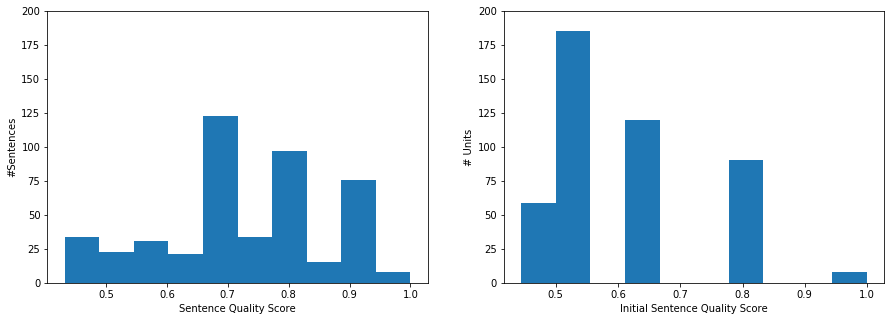

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results["units"]["uqs"])
plt.ylim(0,200)
plt.xlabel("Sentence Quality Score")
plt.ylabel("#Sentences")

plt.subplot(1, 2, 2)
plt.hist(results["units"]["uqs_initial"])
plt.ylim(0,200)
plt.xlabel("Initial Sentence Quality Score")
plt.ylabel("# Units")


The `unit_annotation_score` column in `results["units"]` contains the **sentence-annotation scores**, capturing the likelihood that an annotation is expressed in a sentence. For each sentence, we store a dictionary mapping each annotation to its sentence-annotation score.

In [8]:
results["units"]["unit_annotation_score"].head()

unit
100_1     {u'after': 0.143649950855, u'before': 0.856350...
102_0     {u'after': 0.782360403297, u'before': 0.217639...
102_1     {u'after': 0.15658087953, u'before': 0.8434191...
103_1     {u'after': 0.15658087953, u'before': 0.8434191...
103_11    {u'after': 0.105941791355, u'before': 0.894058...
Name: unit_annotation_score, dtype: object

## Example of a clear unit based on the CrowdTruth metrics

First, we sort the **sentence metrics** stored in *results["units"]* based on the **sentence quality score (uqs)**, in ascending order. Thus, the most clear sentences are found at the tail of the new structure. Because we do not have initial input for all the units, we first filter these out. 

In [9]:
sortedUQS = results["units"].sort_values(["uqs"])
# remove the units for which we don't have the events and the text
sortedUQS = sortedUQS.dropna()
sortedUQS = sortedUQS.reset_index()

We print the most clear unit, which is the last unit in sortedUQS:

In [10]:
sortedUQS.tail(1)

,unit,duration,input.event1,input.event2,input.gold,input.text,job,output.response,output.response.annotations,output.response.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
56,10_3,83,"<font color=""blue"">acquire</font>","<font color=""purple"">reached</font>",after,<p>Ratners Group PLC's U.S. subsidiary has agr...,../data/temp.standardized,"{u'after': 10, u'before': 0}",10,1,10,1.0,"{u'after': 1.0, u'before': 0.0}",1.0,"{u'after': 1.0, u'before': 0.0}"


The following two sentences contain the events that need to be ordered: 

<p>Ratners Group PLC's U.S. subsidiary has agreed to <b><u><font color="blue">acquire</font></u></b> jewelry retailer Weisfield's Inc.

Ratners and Weisfield's said they <b><u><font color="purple">reached</font></u></b> an agreement in principle for the acquisition of Weisfield's by Sterling Inc.

The unit is very clear because the second sentence clearly states that before acquiring Weisfield's Inc, the two parts reached an agreement, which means that <b><u><font color="blue">acquire</font></u></b> happened after <b><u><font color="purple">reached</font></u></b>.

In [11]:
print("Text: %s" % sortedUQS["input.text"].iloc[len(sortedUQS.index)-1])
print("\n Event1: %s" % sortedUQS["input.event1"].iloc[len(sortedUQS.index)-1])
print("\n Event2: %s" % sortedUQS["input.event2"].iloc[len(sortedUQS.index)-1])
print("\n Expert Answer: %s" % sortedUQS["input.gold"].iloc[len(sortedUQS.index)-1])
print("\n Crowd Answer with CrowdTruth: %s" % sortedUQS["unit_annotation_score"].iloc[len(sortedUQS.index)-1])
print("\n Crowd Answer without CrowdTruth: %s" % sortedUQS["unit_annotation_score_initial"].iloc[len(sortedUQS.index)-1])

Text: <p>Ratners Group PLC's U.S. subsidiary has agreed to <b><u><font color="blue">acquire</font></u></b> jewelry retailer Weisfield's Inc. for $50 a share, or about $55 million. <br></br>Weisfield's shares <b><u><font color="green">soared</font></u></b> on the announcement yesterday, closing up $11 to <b><u><font color="orange">close</font></u></b> at $50 in national over-the-counter trading. <br></br>Ratners and Weisfield's <b><u><font color="red">said</font></u></b> they <b><u><font color="purple">reached</font></u></b> an agreement in principle for the acquisition of Weisfield's by Sterling Inc. <br></br>The companies <b><u><font color="brown">said</font></u></b> the acquisition is subject to a definitive agreement. <br></br>They said they expect the transaction to be completed by Dec. 15. <br></br>Weisfield's, based in Seattle, Wash., currently operates 87 specialty jewelry stores in nine states. <br></br>In the fiscal year ended Jan. 31, the company reported sales of $59.5 milli

## Example of an unclear unit based on the CrowdTruth metrics

We use the same structure as above and we print the most unclear unit, which is the first unit in sortedUQS:

In [12]:
sortedUQS.head(1)

,unit,duration,input.event1,input.event2,input.gold,input.text,job,output.response,output.response.annotations,output.response.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
0,6_12,83,"<font color=""red"">turn</font>","<font color=""purple"">said</font>",before,<p>Magna International Inc..'s chief financial...,../data/temp.standardized,"{u'after': 5, u'before': 5}",10,2,10,0.436384,"{u'after': 0.475324306685, u'before': 0.524675...",0.444444,"{u'after': 0.5, u'before': 0.5}"


The following sentence contains the events that need to be ordered: 

Magna International Inc..'s chief financial officer, James McAlpine, resigned and its chairman, Frank Stronach, is stepping in to help <b><u><font color="red">turn</font></u></b> the automotive-parts manufacturer around, the company <b><u><font color="purple">said</font></u></b>.

The unit is unclear due to various reasons. First of all, the sentence is very long and difficult to read. Second, there is a series of events mentioned in the text and third, it is not very clearly stated if the "turning" event is happening prior or after the "announcement".

In [13]:
print("Text: %s" % sortedUQS["input.text"].iloc[0])
print("\n Event1: %s" % sortedUQS["input.event1"].iloc[0])
print("\n Event2: %s" % sortedUQS["input.event2"].iloc[0])
print("\n Expert Answer: %s" % sortedUQS["input.gold"].iloc[0])
print("\n Crowd Answer with CrowdTruth: %s" % sortedUQS["unit_annotation_score"].iloc[0])
print("\n Crowd Answer without CrowdTruth: %s" % sortedUQS["unit_annotation_score_initial"].iloc[0])

Text: <p>Magna International Inc..'s chief financial officer, James McAlpine, <b><u><font color="blue">resigned</font></u></b> and its chairman, Frank Stronach, is <b><u><font color="green">stepping</font></u></b> in to <b><u><font color="orange">help</font></u></b> <b><u><font color="red">turn</font></u></b> the automotive-parts manufacturer around, the company <b><u><font color="purple">said</font></u></b>. <br></br>Mr. Stronach will <b><u><font color="brown">direct</font></u></b> an effort to reduce overhead and curb capital spending'' until a more satisfactory level of profit is achieved and maintained,'' Magna said. <br></br>Stephen Akerfeldt, currently vice president finance, will succeed Mr. McAlpine. <br></br>An ambitious expansion has left Magna with excess capacity and a heavy debt load as the automotive industry enters a downturn. <br></br>The company has reported declines in operating profit in each of the past three years, despite steady sales growth. <br></br>Magna recent

# CrowdTruth Worker Quality Scores

The **worker metrics** are stored in `results["workers"]`:

In [14]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
A1123L7ANYUTG0,83,1,20,20,0.833171,0.858963,0.969973,0.676611,0.738889,0.915714
A11GX90QFWDLMM,83,1,462,462,0.282526,0.504831,0.559645,0.289752,0.489177,0.592326
A13PCLSK1JA8QL,83,1,10,10,0.212647,0.423645,0.501946,0.210866,0.400000,0.527164
A16QMNGIR7N53M,83,1,10,10,0.586793,0.702512,0.835277,0.454946,0.588889,0.772549
A17743NDSCO8P5,83,1,10,10,0.443041,0.625937,0.707804,0.393730,0.566667,0.694817


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.  The `wqs_initial` column in `results["workers"]` contains the **initial worker quality scores**, before appling the CrowdTruth metrics. Here we plot the two histograms:

Text(0,0.5,'#Workers')

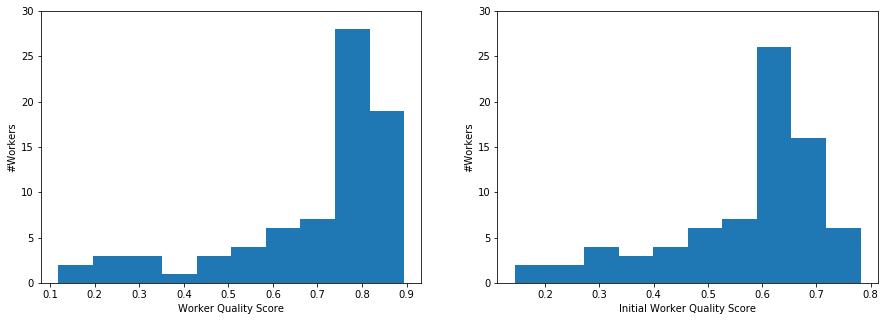

In [15]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results["workers"]["wqs"])
plt.ylim(0,30)
plt.xlabel("Worker Quality Score")
plt.ylabel("#Workers")

plt.subplot(1, 2, 2)
plt.hist(results["workers"]["wqs_initial"])
plt.ylim(0,30)
plt.xlabel("Initial Worker Quality Score")
plt.ylabel("#Workers")



# CrowdTruth Annotation Quality Score

The **annotation metrics** are stored in `results["annotations"]`. The `aqs` column contains the **annotation quality scores**, capturing the overall worker agreement over one annotation.

In [16]:
results["annotations"]

,output.response,aqs,aqs_initial
after,4620,0.836744,0.723143
before,4620,0.824213,0.713564


## Save the unit and worker metrics:

In [17]:
rows = []
header = ["orig_id", "gold", "text", "event1", "event2", "uqs", "uqs_initial", "before", "after", "before_initial", "after_initial"]

units = results["units"].reset_index()
for i in range(len(units.index)):
    row = [units["unit"].iloc[i], units["input.gold"].iloc[i], units["input.text"].iloc[i], units["input.event1"].iloc[i],\
           units["input.event2"].iloc[i], units["uqs"].iloc[i], units["uqs_initial"].iloc[i], \
           units["unit_annotation_score"].iloc[i]["before"], units["unit_annotation_score"].iloc[i]["after"], \
           units["unit_annotation_score_initial"].iloc[i]["before"], units["unit_annotation_score_initial"].iloc[i]["after"]]
    rows.append(row)
rows = pd.DataFrame(rows, columns=header)
rows.to_csv("../data/results/crowdtruth_units_temp.csv", index=False)

In [18]:
results["workers"].to_csv("../data/results/crowdtruth_workers_temp.csv", index=True)

# MACE for Temporal Event Ordering

We first pre-processed the crowd results to create compatible files for running the MACE tool.
Each row in a csv file should point to a unit in the dataset and each column in the csv file should point to a worker. The content of the csv file captures the worker answer for that particular unit (or remains empty if the worker did not annotate that unit).

The following implementation of MACE has been used in these experiments: https://github.com/dirkhovy/MACE.

In [19]:
import numpy as np

mace_test_data = pd.read_csv("../data/mace_temp.standardized.csv", header=None)
mace_test_data = test_data.replace(np.nan, '', regex=True)
mace_test_data.head()

,!amt_annotation_ids,!amt_worker_ids,orig_id,response,gold,start,end,event1,event2,text
0,1,A2HTGQE4AACVRV,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,,,
1,2,AYHHOK9GDSWNH,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,,,
2,3,A1QRQZWBL1SVEX,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,,,
3,4,A3G0MGLBT484I1,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,,,
4,5,A7NC1H5ZK7TO0,42_0,before,before,Mon Mar 25 07:39:42 PDT 2019,Mon Mar 25 07:41:05 PDT 2019,,,


For each unit/sentence and each annotation MACE computes the probability of an annotation to be expressed in the sentence. The probability computed by MACE is similar to the **sentence-annotation score** computed by the CrowdTruth metrics.

In [20]:
import pandas as pd

mace_data = pd.read_csv("../data/results/mace_units_temp.csv")
mace_data.head()

,unit,before,after,gold
0,42_0,1.000000e+00,2.587036e-09,before
1,11_1,9.999999e-01,1.071343e-07,before
2,11_0,5.038665e-08,9.999999e-01,after
3,112_0,5.480848e-08,9.999999e-01,after
4,9_2,1.000000e+00,2.005877e-08,before


For each worker in the annotators set, MACE computes their competence. The competence of a woker computed by MACE is similar to the **worker quality score** computed by the CrowdTruth metrics.

In [21]:
mace_workers = pd.read_csv("../data/results/mace_workers_temp.csv")
mace_workers.head()

,worker,competence
0,A2HTGQE4AACVRV,0.942213
1,AYHHOK9GDSWNH,0.928760
2,A1QRQZWBL1SVEX,0.942213
3,A3G0MGLBT484I1,0.000667
4,A7NC1H5ZK7TO0,0.942213


# CrowdTruth vs. MACE on Worker Quality

We read the worker quality scores as returned by CrowdTruth and MACE

In [22]:
mace_workers = pd.read_csv("../data/results/mace_workers_temp.csv")
crowdtruth_workers = pd.read_csv("../data/results/crowdtruth_workers_temp.csv")

workers_scores = pd.merge(mace_workers, crowdtruth_workers, on='worker')
workers_scores = workers_scores.sort_values(["wqs"])
workers_scores.head()

,worker,competence,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
36,A1VG58HXS2O3JX,0.024258,83,1,10,10,0.118017,0.317905,0.371234,0.144064,0.333333,0.432192
71,A2OZTBCBOCHF9E,0.031294,83,1,10,10,0.133803,0.316495,0.422765,0.161219,0.344444,0.468055
57,A13PCLSK1JA8QL,0.032098,83,1,10,10,0.212647,0.423645,0.501946,0.210866,0.400000,0.527164
3,A3G0MGLBT484I1,0.000667,83,1,360,360,0.240222,0.451157,0.532459,0.221847,0.412963,0.537207
7,A3PIXX8DQGYHGI,0.000726,83,1,452,452,0.271584,0.494997,0.548657,0.278811,0.480088,0.580748


Plot the quality scores of the workers as computed by both CrowdTruth and MACE:

Text(0,0.5,'CrowdTruth')

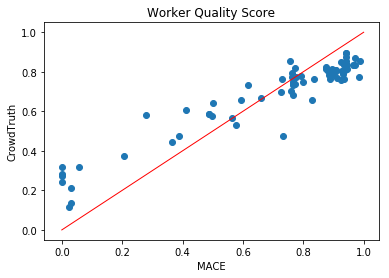

In [23]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.scatter(
    workers_scores["competence"],
    workers_scores["wqs"],
)
plt.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.title("Worker Quality Score")
plt.xlabel("MACE")
plt.ylabel("CrowdTruth")

In the plot above we observe that MACE and CrowdTruth have quite similar worker quality scores. It seems, however, that MACE favours extreme values, which means that the identified low quality workers will have very low scores, e.g., very close to 0.0 and the best workers will have quality scores of 1.0, or very close to 1.0. On the other side, CrowdTruth has a smaller interval of values, starting from around 0.1 to 0.9.

Following, we compute the correlation between the two values using Spearman correlation and Kendall's tau correlation

In [24]:
from scipy.stats import spearmanr
x = workers_scores["wqs"]

x_corr = workers_scores["competence"]
corr, p_value = spearmanr(x, x_corr)
print ("correlation: ", corr)
print ("p-value: ", p_value)

('correlation: ', 0.874882087083834)
('p-value: ', 5.284825872347388e-25)


Spearman correlation shows shows a very strong correlation between the two computed values, and the correlation is significant. This means that overall, even if the two metrics provide different values, they are indeed correlated and low quality workers receive low scores and high quality workers receive higher scores from both aggregation methods.

In [25]:
from scipy.stats import kendalltau
x1 = workers_scores["wqs"]
x2 = workers_scores["competence"]

tau, p_value = kendalltau(x1, x2)
print ("correlation: ", tau)
print ("p-value: ", p_value)

('correlation: ', 0.7107990450658218)
('p-value: ', 1.1071406694268326e-19)


Even with Kendall's tau rank correlation, we observe a strong correlation between the two computed values, where the correlation is significant. This means that the aggregation methods, MACE and CrowdTruth rank the workers based on their quality in a similar way.

Further, we compute the difference of the two quality scores and we check one worker for which the difference is very high.

In [26]:
workers_scores["diff"] = workers_scores["wqs"] - workers_scores["competence"]
workers_scores = workers_scores.sort_values(["diff"])
workers_scores.tail(5)

,worker,competence,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial,diff
9,A18941IO2ZZWW6,0.056011,83,1,442,442,0.319489,0.535886,0.596188,0.322106,0.514580,0.625958,0.263478
7,A3PIXX8DQGYHGI,0.000726,83,1,452,452,0.271584,0.494997,0.548657,0.278811,0.480088,0.580748,0.270857
6,A11GX90QFWDLMM,0.001634,83,1,462,462,0.282526,0.504831,0.559645,0.289752,0.489177,0.592326,0.280892
43,A2MIF2GUSZLJ0X,0.277989,83,1,20,20,0.578861,0.714147,0.810562,0.468166,0.611111,0.766090,0.300872
8,A2KONK3TIL5KVX,0.002004,83,1,132,132,0.320038,0.523473,0.611374,0.281830,0.465488,0.605449,0.318033


We take for example the worker with the id "A2KONK3TIL5KVX" and check the overall disagreement among the workers on the units annotated by them. MACE rated the worker with a quality score of 0.002 while CrowdTruth rated the worker with a higher quality score of 0.32.

In [27]:
units = list(test_data[test_data["!amt_worker_ids"] == "A2KONK3TIL5KVX"]["orig_id"])
all_results = results["units"].reset_index()
units_df = all_results[all_results["unit"].isin(units)]
units_df = units_df.sort_values(["uqs_initial"])
units_df.head(10)

,unit,duration,input.event1,input.event2,input.gold,input.text,job,output.response,output.response.annotations,output.response.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
178,156_1,83,NaN,NaN,after,NaN,../data/temp.standardized,"{u'after': 5, u'before': 5}",10,2,10,0.432978,"{u'after': 0.485536823066, u'before': 0.514463...",0.444444,"{u'after': 0.5, u'before': 0.5}"
134,141_6,83,NaN,NaN,after,NaN,../data/temp.standardized,"{u'after': 5, u'before': 5}",10,2,10,0.437760,"{u'after': 0.452401258721, u'before': 0.547598...",0.444444,"{u'after': 0.5, u'before': 0.5}"
175,154_18,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 5, u'before': 5}",10,2,10,0.433666,"{u'after': 0.477327447824, u'before': 0.522672...",0.444444,"{u'after': 0.5, u'before': 0.5}"
60,119_12,83,NaN,NaN,after,NaN,../data/temp.standardized,"{u'after': 5, u'before': 5}",10,2,10,0.434827,"{u'after': 0.541049740586, u'before': 0.458950...",0.444444,"{u'after': 0.5, u'before': 0.5}"
59,119_11,83,NaN,NaN,after,NaN,../data/temp.standardized,"{u'after': 5, u'before': 5}",10,2,10,0.435223,"{u'after': 0.543114175739, u'before': 0.456885...",0.444444,"{u'after': 0.5, u'before': 0.5}"
179,157_0,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 5, u'before': 5}",10,2,10,0.432978,"{u'after': 0.485536823066, u'before': 0.514463...",0.444444,"{u'after': 0.5, u'before': 0.5}"
296,32_11,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 6, u'before': 4}",10,2,10,0.516423,"{u'after': 0.694045156627, u'before': 0.305954...",0.466667,"{u'after': 0.6, u'before': 0.4}"
298,32_14,83,NaN,NaN,after,NaN,../data/temp.standardized,"{u'after': 6, u'before': 4}",10,2,10,0.528515,"{u'after': 0.706536575636, u'before': 0.293463...",0.466667,"{u'after': 0.6, u'before': 0.4}"
162,149_7,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 4, u'before': 6}",10,2,10,0.453772,"{u'after': 0.399169682956, u'before': 0.600830...",0.466667,"{u'after': 0.4, u'before': 0.6}"
135,141_9,83,NaN,NaN,before,NaN,../data/temp.standardized,"{u'after': 4, u'before': 6}",10,2,10,0.488398,"{u'after': 0.34302182787, u'before': 0.6569781...",0.466667,"{u'after': 0.4, u'before': 0.6}"


What we observe in the dataframe above, is that the worker "A2KONK3TIL5KVX" annotated many units with high disagreement, i.e., which are not very clear. While MACE marked the worker as low quality because it seems that they always picked the same answer, CrowdTruth also considered the difficulty of the units, and thus, giving it a higher weight. 

# CrowdTruth vs. MACE vs. Majority Vote on Annotation Performance

Next, we look into the crowd performance in terms of F1-score compared to expert annotations. We compare the crowd performance given the three aggregation methods: CrowdTruth, MACE and Majority Vote. We read the result files as given by MACE and CrowdTruth.

In [28]:
mace = pd.read_csv("../data/results/mace_units_temp.csv")
crowdtruth = pd.read_csv("../data/results/crowdtruth_units_temp.csv")

The following two functions compute the F1-score of the crowd compared to the expert annotations. The first function computes the F1-score at every sentence-annotation score threshold. The second function computes the F1-score for the majority vote approach, i.e., when at least half of the workers picked the answer.

In [29]:
def compute_F1_score(dataset, label, gold_column, gold_value):
    nyt_f1 = np.zeros(shape=(100, 2))
    for idx in xrange(0, 100):
        thresh = (idx + 1) / 100.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for gt_idx in range(0, len(dataset.index)):
            if dataset[label].iloc[gt_idx] >= thresh:
                if dataset[gold_column].iloc[gt_idx] == gold_value:
                    tp = tp + 1.0
                else:
                    fp = fp + 1.0
            else:
                if dataset[gold_column].iloc[gt_idx] == gold_value:
                    fn = fn + 1.0
                else:
                    tn = tn + 1.0


        nyt_f1[idx, 0] = thresh
    
        if tp != 0:
            nyt_f1[idx, 1] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 1] = 0
    return nyt_f1


def compute_majority_vote(dataset, label, gold_column, gold_value):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for j in range(len(dataset.index)):
        if dataset[label].iloc[j] >= 0.5:
            if dataset[gold_column].iloc[j] == gold_value:
                tp = tp + 1.0
            else:
                fp = fp + 1.0
        else:
            if dataset[gold_column].iloc[j] == gold_value:
                fn = fn + 1.0
            else:
                tn = tn + 1.0
    return 2.0 * tp / (2.0 * tp + fp + fn)

F1-score for the annotation "before":

In [30]:
F1_crowdtruth = compute_F1_score(crowdtruth, "before", "gold", "before")
print("Best CrowdTruth F1 score for annotation 'before': ", F1_crowdtruth[F1_crowdtruth[:,1].argsort()][-1:])
F1_mace = compute_F1_score(mace, "before", "gold", "before")
print("Best MACE F1 score for annotation 'before': ", F1_mace[F1_mace[:,1].argsort()][-1:])
F1_majority_vote = compute_majority_vote(crowdtruth, 'before_initial', "gold", "before")
print("Majority Vote F1 score for annotation 'before': ", F1_majority_vote)

("Best CrowdTruth F1 score for annotation 'before': ", array([[0.51      , 0.95107632]]))
("Best MACE F1 score for annotation 'before': ", array([[0.95      , 0.94921875]]))
("Majority Vote F1 score for annotation 'before': ", 0.9455252918287937)


F1-score for the annotation "after":

In [31]:
F1_crowdtruth = compute_F1_score(crowdtruth, "after", "gold", "after")
print("Best CrowdTruth F1 score for annotation 'after': ", F1_crowdtruth[F1_crowdtruth[:,1].argsort()][-1:])
F1_mace = compute_F1_score(mace, "after", "gold", "after")
print("Best MACE F1 score for annotation 'after': ", F1_mace[F1_mace[:,1].argsort()][-1:])
F1_majority_vote = compute_majority_vote(crowdtruth, 'after_initial', "gold", "after")
print("Majority Vote F1 score for annotation 'after': ", F1_majority_vote)

("Best CrowdTruth F1 score for annotation 'after': ", array([[0.48      , 0.93975904]]))
("Best MACE F1 score for annotation 'after': ", array([[0.05     , 0.9368932]]))
("Majority Vote F1 score for annotation 'after': ", 0.927400468384075)


From the results above we observe that MACE and CrowdTruth perform very close to each other, and they both perform better than majority vote.

To further explore the CrowdTruth and MACE quality metrics, download the aggregation results in .csv format for:

* [CrowdTruth units quality](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/crowdtruth_units_temp.csv)
* [CrowdTruth workers quality](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/crowdtruth_workers_temp.csv)
* [MACE units quality](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/mace_units_temp.csv)
* [MACE workers quality](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/data/results/mace_workers_temp.csv)